# Import Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [ ]:
df_train=pd.read_csv('../datasets/train_weather.csv',parse_dates=['date'])

In [ ]:
df_train['wnv']=df_train['wnv'].map(lambda x: 0 if x==0 else 1)

In [ ]:
df_train

,wetbulb,wetbulb_rolling_14,wetbulb_rolling_14_lag_10,dewpoint,dewpoint_rolling_14,dewpoint_rolling_14_lag_10,tmin,tmin_rolling_14,tmin_rolling_14_lag_10,tavg,...,preciptotal_rolling_14,preciptotal_rolling_14_lag_7,avgspeed,avgspeed_rolling_14,lat,long,cool,heat,date,wnv
0,65,58.285714,53.214286,58,49.857143,42.214286,60,57.642857,51.571429,74,...,0.108571,0.020714,6.5,9.557143,41.954690,-87.800991,9,0,2007-05-29,0
1,65,58.285714,53.214286,58,49.857143,42.214286,60,57.642857,51.571429,74,...,0.108571,0.020714,6.5,9.557143,41.954690,-87.800991,9,0,2007-05-29,0
2,65,58.285714,53.214286,58,49.857143,42.214286,60,57.642857,51.571429,74,...,0.108571,0.020714,6.5,9.557143,41.994991,-87.769279,9,0,2007-05-29,0
3,65,58.285714,53.214286,58,49.857143,42.214286,60,57.642857,51.571429,74,...,0.108571,0.020714,6.5,9.557143,41.974089,-87.824812,9,0,2007-05-29,0
4,65,58.285714,53.214286,58,49.857143,42.214286,60,57.642857,51.571429,74,...,0.108571,0.020714,6.5,9.557143,41.974089,-87.824812,9,0,2007-05-29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,58,55.428571,58.785714,52,50.142857,54.428571,55,51.928571,57.357143,65,...,0.001429,0.137143,4.6,7.607143,41.912563,-87.668055,0,0,2013-09-26,0
8471,58,56.214286,58.714286,52,51.142857,54.071429,50,53.000000,57.357143,63,...,0.001429,0.137143,4.2,7.992857,42.009876,-87.807277,0,2,2013-09-26,0
8472,58,55.428571,58.785714,52,50.142857,54.428571,55,51.928571,57.357143,65,...,0.001429,0.137143,4.6,7.607143,41.776428,-87.627096,0,0,2013-09-26,0
8473,58,56.214286,58.714286,52,51.142857,54.071429,50,53.000000,57.357143,63,...,0.001429,0.137143,4.2,7.992857,41.974689,-87.890615,0,2,2013-09-26,0


In [ ]:
y=df_train['wnv']
X=df_train.drop(columns=['wnv','date'])

In [ ]:
y.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: wnv, dtype: float64

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y)

In [ ]:
y_test.value_counts(normalize=True)

0    0.946201
1    0.053799
Name: wnv, dtype: float64

In [ ]:
ss=StandardScaler()
X_train_sc=pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test_sc=pd.DataFrame(ss.transform(X_test),columns=X_test.columns,index=X_test.index)

In [ ]:
X_train_sc

,wetbulb,wetbulb_rolling_14,wetbulb_rolling_14_lag_10,dewpoint,dewpoint_rolling_14,dewpoint_rolling_14_lag_10,tmin,tmin_rolling_14,tmin_rolling_14_lag_10,tavg,...,hz_rolling_14_lag_7,preciptotal,preciptotal_rolling_14,preciptotal_rolling_14_lag_7,avgspeed,avgspeed_rolling_14,lat,long,cool,heat
4903,-0.804139,0.409570,-0.400908,-0.538605,0.761898,-0.294206,-0.464361,0.195446,-0.596783,-1.143459,...,-0.965302,-0.398935,0.032953,1.099194,0.462932,1.751266,-0.481082,0.481207,-1.489587,0.016994
6913,1.106116,0.409570,-0.356939,1.343886,0.570766,-0.206417,0.964423,0.245425,0.023886,0.821526,...,0.000152,1.994650,-0.227543,-0.800310,1.180444,-0.422668,-0.647089,-1.000369,0.912584,-0.341854
1961,0.224460,0.025101,0.551745,0.088892,-0.117309,0.684017,-0.074693,-0.129421,0.398873,0.428529,...,-0.965302,-0.398935,-0.838216,-0.605782,-1.290986,-0.933449,0.715979,-1.193483,0.397833,-0.341854
907,0.812231,0.694362,0.141371,0.465390,0.545281,0.082034,0.704644,0.720230,0.243706,0.952525,...,1.931060,-0.398935,-0.287330,-0.205284,-1.530156,-0.759036,-0.179521,0.319697,1.084168,-0.341854
786,0.812231,0.694362,0.141371,0.465390,0.545281,0.082034,0.704644,0.720230,0.243706,0.952525,...,1.931060,-0.398935,-0.287330,-0.205284,-1.530156,-0.759036,-0.740648,1.566548,1.084168,-0.341854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7607,-0.363311,0.167497,-0.459533,-0.538605,0.201244,-0.319289,0.704644,0.295405,-0.428685,0.166531,...,-0.482575,-0.398935,-0.334304,0.103671,1.300029,0.723475,-1.541978,1.895567,0.054666,-0.341854
4235,-0.510254,-0.501764,0.405183,0.088892,-0.168278,0.583686,-0.334471,-0.641711,0.373012,-1.143459,...,-0.965302,2.308095,0.336155,0.361134,0.861550,1.010011,1.118251,0.034737,-1.489587,0.016994
2855,-1.979681,-1.811806,-1.690653,-1.542600,-1.646365,-1.460549,-1.763255,-1.941177,-1.476064,-2.191451,...,0.000152,-0.227965,-0.210462,0.916109,0.662241,0.038281,0.433451,0.478153,-1.489587,2.887774
5920,-0.069426,0.324132,0.390527,-0.162107,0.430602,0.345401,-0.334471,0.245425,0.256637,-0.095467,...,-0.482575,-0.398935,0.255016,0.292477,-1.649742,-0.846243,-1.144875,0.531870,-0.288501,-0.341854


In [ ]:
smote=SMOTE(random_state=42, k_neighbors=5)
X_train_sc_sm,y_train_sm=smote.fit_resample(X_train_sc,y_train)

## Recursive Feature Elimination

In [ ]:
rfe=RFECV(estimator=XGBClassifier(use_label_encoder=False),
          step=1,
          cv=5,
          scoring='roc_auc'
         )

In [ ]:
rfe.fit(X_train_sc_sm,y_train_sm)

[16:55:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:55:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:56:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:57:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:57:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:58:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:58:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[17:00:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:00:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[17:01:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[17:02:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:02:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[17:03:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, gamma=None, gpu_id=None,
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              use_label_encoder=False, validate_parameters=None,
                              verbosity=None),
      scoring='roc_auc')

In [ ]:
X_train_sc=X_train_sc.loc[:,rfe.get_support()]

In [ ]:
X_train_sc

,wetbulb,wetbulb_rolling_14,wetbulb_rolling_14_lag_10,dewpoint,dewpoint_rolling_14,dewpoint_rolling_14_lag_10,tmin,tmin_rolling_14,tmin_rolling_14_lag_10,tavg,...,hz_rolling_14,hz_rolling_14_lag_7,preciptotal,preciptotal_rolling_14,preciptotal_rolling_14_lag_7,avgspeed,avgspeed_rolling_14,lat,long,cool
4903,-0.804139,0.409570,-0.400908,-0.538605,0.761898,-0.294206,-0.464361,0.195446,-0.596783,-1.143459,...,-0.991519,-0.965302,-0.398935,0.032953,1.099194,0.462932,1.751266,-0.481082,0.481207,-1.489587
6913,1.106116,0.409570,-0.356939,1.343886,0.570766,-0.206417,0.964423,0.245425,0.023886,0.821526,...,0.068993,0.000152,1.994650,-0.227543,-0.800310,1.180444,-0.422668,-0.647089,-1.000369,0.912584
1961,0.224460,0.025101,0.551745,0.088892,-0.117309,0.684017,-0.074693,-0.129421,0.398873,0.428529,...,-0.991519,-0.965302,-0.398935,-0.838216,-0.605782,-1.290986,-0.933449,0.715979,-1.193483,0.397833
907,0.812231,0.694362,0.141371,0.465390,0.545281,0.082034,0.704644,0.720230,0.243706,0.952525,...,2.720275,1.931060,-0.398935,-0.287330,-0.205284,-1.530156,-0.759036,-0.179521,0.319697,1.084168
786,0.812231,0.694362,0.141371,0.465390,0.545281,0.082034,0.704644,0.720230,0.243706,0.952525,...,2.720275,1.931060,-0.398935,-0.287330,-0.205284,-1.530156,-0.759036,-0.740648,1.566548,1.084168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7607,-0.363311,0.167497,-0.459533,-0.538605,0.201244,-0.319289,0.704644,0.295405,-0.428685,0.166531,...,-0.991519,-0.482575,-0.398935,-0.334304,0.103671,1.300029,0.723475,-1.541978,1.895567,0.054666
4235,-0.510254,-0.501764,0.405183,0.088892,-0.168278,0.583686,-0.334471,-0.641711,0.373012,-1.143459,...,-0.991519,-0.965302,2.308095,0.336155,0.361134,0.861550,1.010011,1.118251,0.034737,-1.489587
2855,-1.979681,-1.811806,-1.690653,-1.542600,-1.646365,-1.460549,-1.763255,-1.941177,-1.476064,-2.191451,...,0.068993,0.000152,-0.227965,-0.210462,0.916109,0.662241,0.038281,0.433451,0.478153,-1.489587
5920,-0.069426,0.324132,0.390527,-0.162107,0.430602,0.345401,-0.334471,0.245425,0.256637,-0.095467,...,-0.991519,-0.482575,-0.398935,0.255016,0.292477,-1.649742,-0.846243,-1.144875,0.531870,-0.288501


In [ ]:
X_test_sc=X_test_sc[X_train_sc.columns]

In [ ]:
X_test_sc

,wetbulb,wetbulb_rolling_14,wetbulb_rolling_14_lag_10,dewpoint,dewpoint_rolling_14,dewpoint_rolling_14_lag_10,tmin,tmin_rolling_14,tmin_rolling_14_lag_10,tavg,...,hz_rolling_14,hz_rolling_14_lag_7,preciptotal,preciptotal_rolling_14,preciptotal_rolling_14_lag_7,avgspeed,avgspeed_rolling_14,lat,long,cool
5602,0.959173,1.676893,1.533710,1.092887,1.717557,1.474120,0.834534,1.444933,1.510905,0.559528,...,0.068993,-0.482575,-0.398935,-0.535015,0.721582,-0.613336,-1.238672,-1.319915,1.533552,0.569417
792,0.812231,0.694362,0.141371,0.465390,0.545281,0.082034,0.704644,0.720230,0.243706,0.952525,...,2.720275,1.931060,-0.398935,-0.287330,-0.205284,-1.530156,-0.759036,-0.220125,0.795337,1.084168
1935,0.224460,0.025101,0.551745,0.088892,-0.117309,0.684017,-0.074693,-0.129421,0.398873,0.428529,...,-0.991519,-0.965302,-0.398935,-0.838216,-0.605782,-1.290986,-0.933449,0.938662,-1.640036,0.397833
3580,-1.098024,-0.516004,-0.210377,-0.915103,-0.881837,-0.319289,-0.724140,-0.166906,-0.118351,-1.143459,...,-0.461263,0.000152,-0.398935,0.246476,0.086507,1.140582,0.922804,-0.182266,-0.378025,-1.489587
5991,1.546944,0.124778,0.331902,1.469385,0.112049,0.433191,0.964423,0.045507,0.230775,1.214523,...,-0.991519,-0.965302,-0.398935,-0.791242,-0.342598,-0.653197,-0.989511,1.376284,-0.622362,1.427335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,0.224460,-0.273931,0.199996,0.088892,-0.435863,0.194905,0.834534,-0.066947,0.243706,0.559528,...,-0.461263,0.000152,-0.398935,-0.765619,0.956159,-0.214718,-0.466271,-1.319915,1.533552,0.569417
3408,0.371403,-0.359368,-0.738000,0.590890,-0.346668,-0.620280,-0.074693,-0.291854,-0.351102,0.035532,...,0.068993,0.000152,-0.170975,-0.535015,-0.703046,-1.051815,-1.637331,1.534988,-0.988416,-0.116918
1825,0.665288,0.822518,0.243965,0.967388,1.271583,0.408108,0.704644,0.657756,0.347151,0.297530,...,0.068993,0.000152,0.170966,3.675639,2.529543,-0.095133,-0.055155,-1.161051,0.554517,0.226250
641,0.812231,-0.060337,0.097403,1.092887,-0.181020,0.144740,0.834534,0.132971,0.127331,0.559528,...,0.599250,0.000152,0.085481,-0.304411,0.692975,0.144038,-0.977052,1.448658,-1.198295,0.569417


## Modeling

- Logistic Regression with SMOTE (LR)
- K-Nearest Neighbors with SMOTE (KNN)
- Random Forest with SMOTE (RF)
- Extra Trees with SMOTE (ET)
- Support Vector Machine with SMOTE (SVM)
- XGBoost with SMOTE (XGB)

### Pipeline: Logistic Regression with SMOTE

In [ ]:
pp_smote_lr=Pipeline([
    ('sampling',SMOTE(random_state=42)),
    ('lr', LogisticRegression(solver='liblinear',max_iter=1000))
])

In [ ]:
pp_smote_lr.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)),
  ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'lr': LogisticRegression(max_iter=1000, solver='liblinear'),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 1000,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'liblinear',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [ ]:
pp_smote_lr_params={
    'sampling__k_neighbors':[5,6,7],
    'sampling__sampling_strategy':['minority', 'not minority','auto'],
    'lr__C':[0.2,0.4,0.6],
    'lr__penalty':['l1','l2']
}

In [ ]:
gs_smote_lr=GridSearchCV(pp_smote_lr,pp_smote_lr_params,cv=5,scoring='roc_auc',verbose=2)

In [ ]:
gs_smote_lr.fit(X_train_sc,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.6s
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.4s
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.9s
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   2.1s
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   2.2s
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END lr__C=0.2, lr__penalty=l1, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; t

[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END lr__C=0.2, lr__penalty=l2, sampling__k_neighbors=7, sampling__sampl

[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END lr__C=0.4, lr__penalty=l2, sampling__k_neighbors=6, sam

[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=  10.4s
[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   5.1s
[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=  15.0s
[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   1.3s
[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   1.8s
[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   1.1s
[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   0.9s
[CV] END lr__C=0.6, lr__penalty=l1, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   1.1s
[CV] END lr__C=0.6, lr__penalty=l1, 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': [0.2, 0.4, 0.6], 'lr__penalty': ['l1', 'l2'],
                         'sampling__k_neighbors': [5, 6, 7],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=2)

In [ ]:
gs_smote_lr.score(X_train_sc,y_train)

0.8153854209950355

In [ ]:
gs_smote_lr.score(X_test_sc,y_test)

0.8254845342783391

In [ ]:
gs_smote_lr.best_estimator_

Pipeline(steps=[('sampling', SMOTE(k_neighbors=7, random_state=42)),
                ('lr',
                 LogisticRegression(C=0.6, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [ ]:
model_lr=gs_smote_lr.best_estimator_

In [ ]:
pred_lr=model_lr.predict(X_test_sc)

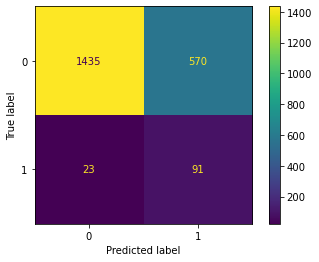

In [ ]:
plot_confusion_matrix(model_lr,X_test_sc,y_test)

In [ ]:
roc_auc_score(y_train,model_lr.predict(X_train_sc))

0.7462928960042358

In [ ]:
roc_auc_score(y_test,pred_lr)

0.7569781686135538

In [ ]:
score=dict()

In [ ]:
score['LR']={'train_acc':gs_smote_lr.score(X_train_sc,y_train),
              'val_acc':gs_smote_lr.best_score_,
              'test_acc':gs_smote_lr.score(X_test_sc,y_test),
              'train_auc':roc_auc_score(y_train,model_lr.predict(X_train_sc)),
              'test_auc':roc_auc_score(y_test,pred_lr),
              'train_recall':recall_score(y_train,model_lr.predict(X_train_sc)),
              'test_recall':recall_score(y_test,pred_lr)
}

### Pipeline: K Nearest Neighbors with SMOTE

In [ ]:
pp_smote_knn=Pipeline([
    ('sampling',SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [ ]:
pp_smote_knn.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(random_state=42)),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'sampling': SMOTE(random_state=42),
 'knn': KNeighborsClassifier(),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [ ]:
pp_smote_knn_params={
    'sampling__k_neighbors':[5,6,7],
    'sampling__sampling_strategy':['minority', 'not minority','auto'],
    'knn__n_neighbors':[5,6,7],
    'knn__weights':['uniform','distance']
}

In [ ]:
gs_smote_knn=GridSearchCV(pp_smote_knn,pp_smote_knn_params,cv=5,scoring='roc_auc',verbose=2)

In [ ]:
gs_smote_knn.fit(X_train_sc,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END knn__n_neighbors=5, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.4s
[CV] END knn__n_neighbors=5, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.3s
[CV] END knn__n_neighbors=5, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.2s

[CV] END knn__n_neighbors=5, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   0.3s
[CV] END knn__n_neighbors=5, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   0.3s
[CV] END knn__n_neighbors=5, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=5, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=5, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=5, knn__weights=dist

[CV] END knn__n_neighbors=6, knn__weights=uniform, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   0.2s
[CV] END knn__n_neighbors=6, knn__weights=uniform, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=6, knn__weights=uniform, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=6, knn__weights=uniform, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=6, knn__weights=uniform, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=6, knn__weights=uniform, sampling__k_neighbors=7, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=6, knn__weights=uniform, sampling__k_neighbors=7, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=6, knn__weights=uniform, sa

[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=7, knn__weights=uniform, sampling__k_ne

[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.1s
[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.3s
[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.2s
[CV] END knn__n_neighbors=7, knn__weights=distance, sampling__k_neighbors=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 6, 7],
                         'knn__weights': ['uniform', 'distance'],
                         'sampling__k_neighbors': [5, 6, 7],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=2)

In [ ]:
gs_smote_knn.score(X_train_sc,y_train)

0.9753212063851936

In [ ]:
gs_smote_knn.score(X_test_sc,y_test)

0.7752439077744235

In [ ]:
gs_smote_knn.best_estimator_

Pipeline(steps=[('sampling',
                 SMOTE(k_neighbors=6, random_state=42,
                       sampling_strategy='minority')),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

In [ ]:
model_knn=gs_smote_knn.best_estimator_

In [ ]:
pred_knn=model_knn.predict(X_test_sc)

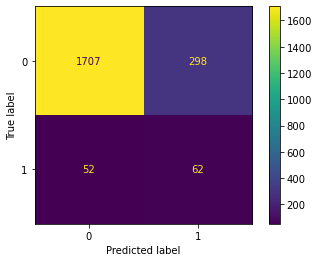

In [ ]:
plot_confusion_matrix(model_knn,X_test_sc,y_test)

In [ ]:
roc_auc_score(y_train,model_knn.predict(X_train_sc))

0.9165617352878288

In [ ]:
roc_auc_score(y_test,pred_knn)

0.697615610097563

In [ ]:
score['KNN']={'train_acc':gs_smote_knn.score(X_train_sc,y_train),
              'val_acc':gs_smote_knn.best_score_,
              'test_acc':gs_smote_knn.score(X_test_sc,y_test),
              'train_auc':roc_auc_score(y_train,model_knn.predict(X_train_sc)),
              'test_auc':roc_auc_score(y_test,pred_knn),
              'train_recall':recall_score(y_train,model_knn.predict(X_train_sc)),
              'test_recall':recall_score(y_test,pred_knn)
}

### Pipeline: Random Forest Classifier with SMOTE

In [ ]:
pp_smote_rf=Pipeline([
    ('sampling',SMOTE(random_state=42)),
    ('rf',RandomForestClassifier(random_state=42))
])

In [ ]:
pp_smote_rf_params={
    'sampling__k_neighbors':[5,6,7,8],
    'sampling__sampling_strategy':['minority', 'not minority', 'auto'],
    'rf__max_depth':[4,5,6],
    'rf__n_estimators':[100,200,300]
}

In [ ]:
gs_smote_rf=GridSearchCV(pp_smote_rf,pp_smote_rf_params,cv=5,scoring='roc_auc',verbose=2)

In [ ]:
gs_smote_rf.fit(X_train_sc,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END rf__max_depth=4, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.3s
[CV] END rf__max_depth=4, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.3s
[CV] END rf__max_de

[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.1s
[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.6s
[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.6s
[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.7s
[CV] END rf__max_depth=4, rf__n_estimators=200, sampling__k_neighbors=

[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.8s
[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.9s
[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.8s
[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.8s
[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END rf__max_depth=4, rf__n_estimators=300, sampling__k_neighbors=5, sampling__sam

[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.3s
[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.7s
[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.7s
[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.7s
[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.6s
[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   0.7s
[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   0.7s
[CV] END rf__max_depth=5, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=minor

[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.3s
[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.3s
[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.3s
[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.3s
[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.3s
[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.3s
[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.3s
[CV] END rf__max_depth=5, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strate

[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   2.2s
[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   2.1s
[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   2.1s
[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.0s
[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.0s
[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.9s
[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.0s
[CV] END rf__max_depth=5, rf__n_estimators=300, sampling__k_neighbors=6, s

[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.4s
[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.5s
[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.4s
[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.4s
[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.8s
[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.7s
[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   0.7s
[CV] END rf__max_depth=6, rf__n_estimators=100, sampling__k_neighbors=6, sampling__sam

[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.7s
[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.5s
[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.5s
[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.5s
[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.5s
[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.5s
[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   1.5s
[CV] END rf__max_depth=6, rf__n_estimators=200, sampling__k_neighbors=7, sampling__sampling_strategy=minor

[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   2.2s
[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   2.2s
[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.4s
[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.4s
[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.4s
[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.5s
[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.2s
[CV] END rf__max_depth=6, rf__n_estimators=300, sampling__k_neighbors=7, sampling__sampling_strate

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [4, 5, 6],
                         'rf__n_estimators': [100, 200, 300],
                         'sampling__k_neighbors': [5, 6, 7, 8],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=2)

In [ ]:
gs_smote_rf.score(X_train_sc,y_train)

0.9012533097627639

In [ ]:
gs_smote_rf.score(X_test_sc,y_test)

0.8542612766329789

In [ ]:
gs_smote_rf.best_estimator_

Pipeline(steps=[('sampling',
                 SMOTE(random_state=42, sampling_strategy='not minority')),
                ('rf',
                 RandomForestClassifier(max_depth=6, n_estimators=300,
                                        random_state=42))])

In [ ]:
model_rf=gs_smote_rf.best_estimator_

In [ ]:
pred_rf=model_rf.predict(X_test_sc)

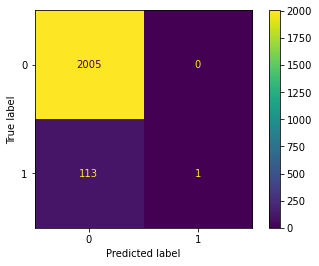

In [ ]:
plot_confusion_matrix(model_rf,X_test_sc,y_test)

In [ ]:
roc_auc_score(y_train,model_knn.predict(X_train_sc))

0.9165617352878288

In [ ]:
roc_auc_score(y_test,pred_knn)

0.697615610097563

In [ ]:
score['RF']={'train_acc':gs_smote_rf.score(X_train_sc,y_train),
              'val_acc':gs_smote_rf.best_score_,
              'test_acc':gs_smote_rf.score(X_test_sc,y_test),
              'train_auc':roc_auc_score(y_train,model_rf.predict(X_train_sc)),
              'test_auc':roc_auc_score(y_test,pred_rf),
              'train_recall':recall_score(y_train,model_rf.predict(X_train_sc)),
              'test_recall':recall_score(y_test,pred_rf)
}

### Pipeline: Extra Trees Classifiers with Smoothing

In [ ]:
pp_smote_et=Pipeline([
    ('sampling',SMOTE(random_state=42)),
    ('et',ExtraTreesClassifier(random_state=42))
])

In [ ]:
pp_smote_et_params={
    'sampling__k_neighbors':[5,6,7,8],
    'sampling__sampling_strategy':['minority', 'not minority', 'auto'],
    'et__max_depth':[6,7,8],
    'et__n_estimators':[300,400,500]
}

In [ ]:
gs_smote_et=GridSearchCV(pp_smote_et,pp_smote_et_params,cv=5,scoring='roc_auc',verbose=2)

In [ ]:
gs_smote_et.fit(X_train_sc,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END et__max_depth=6, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.1s
[CV] END et__max_depth=6, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.1s
[CV] END et__max_depth=6, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.1s
[CV] END et__max_depth=6, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.1s
[CV] END et__max_depth=6, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.1s
[CV] END et__max_depth=6, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.7s
[CV] END et__max_depth=6, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.7s
[CV] END et__max_de

[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.5s
[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=minority; total time=   1.5s
[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.0s
[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.0s
[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.2s
[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.0s
[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.0s
[CV] END et__max_depth=6, et__n_estimators=400, sampling__k_neighbors=

[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.2s
[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.2s
[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.2s
[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   1.2s
[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.8s
[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.8s
[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   2.0s
[CV] END et__max_depth=6, et__n_estimators=500, sampling__k_neighbors=5, sampling__sam

[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=not minority; total time=   0.8s
[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.3s
[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.4s
[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.5s
[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.4s
[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.5s
[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.4s
[CV] END et__max_depth=7, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=minor

[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.6s
[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=5, sampling__sampling_strategy=auto; total time=   1.6s
[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.5s
[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.6s
[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.6s
[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.5s
[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.6s
[CV] END et__max_depth=7, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strate

[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   2.0s
[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   2.0s
[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=minority; total time=   1.9s
[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.2s
[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.3s
[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.3s
[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.3s
[CV] END et__max_depth=7, et__n_estimators=500, sampling__k_neighbors=6, s

[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.8s
[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.8s
[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.9s
[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   0.8s
[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.3s
[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.3s
[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.3s
[CV] END et__max_depth=8, et__n_estimators=300, sampling__k_neighbors=6, sampling__sam

[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=not minority; total time=   1.1s
[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   1.7s
[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   1.7s
[CV] END et__max_depth=8, et__n_estimators=400, sampling__k_neighbors=7, sampling__sampling_strategy=minor

[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   2.2s
[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=6, sampling__sampling_strategy=auto; total time=   2.2s
[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.1s
[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.2s
[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.2s
[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.2s
[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=7, sampling__sampling_strategy=minority; total time=   2.2s
[CV] END et__max_depth=8, et__n_estimators=500, sampling__k_neighbors=7, sampling__sampling_strate

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('et',
                                        ExtraTreesClassifier(random_state=42))]),
             param_grid={'et__max_depth': [6, 7, 8],
                         'et__n_estimators': [300, 400, 500],
                         'sampling__k_neighbors': [5, 6, 7, 8],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc', verbose=2)

In [ ]:
gs_smote_et.score(X_train_sc,y_train)

0.9096151729561653

In [ ]:
gs_smote_et.score(X_test_sc,y_test)

0.848064050400315

In [ ]:
gs_smote_et.best_estimator_

Pipeline(steps=[('sampling',
                 SMOTE(random_state=42, sampling_strategy='not minority')),
                ('et',
                 ExtraTreesClassifier(max_depth=8, n_estimators=300,
                                      random_state=42))])

In [ ]:
model_et=gs_smote_et.best_estimator_

In [ ]:
pred_et=model_et.predict(X_test_sc)

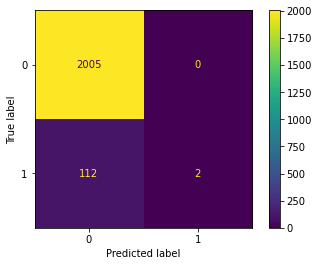

In [ ]:
plot_confusion_matrix(model_et,X_test_sc,y_test)

In [ ]:
roc_auc_score(y_train,model_et.predict(X_train_sc))

0.5087463556851312

In [ ]:
roc_auc_score(y_test,pred_et)

0.5087719298245614

In [ ]:
score['ET']={'train_acc':gs_smote_et.score(X_train_sc,y_train),
              'val_acc':gs_smote_et.best_score_,
              'test_acc':gs_smote_et.score(X_test_sc,y_test),
              'train_auc':roc_auc_score(y_train,model_et.predict(X_train_sc)),
              'test_auc':roc_auc_score(y_test,pred_et),
              'train_recall':recall_score(y_train,model_et.predict(X_train_sc)),
              'test_recall':recall_score(y_test,pred_et)
}

### Pipeline: Support Vector Machines with SMOTE

In [ ]:
pp_smote_svc=Pipeline([
    ('sampling',SMOTE()),
    ('svc',SVC(probability=True))
])

In [ ]:
pp_smote_svc_params={
# params was executed but poly kernel has better results hence these features was comment out to ensure notebook run faster
#     {'sampling__k_neighbors':[5,6,7],
#      'sampling__sampling_strategy':['minority', 'not minority', 'auto'],
#      'svc__C':[0.2,0.4],
#      'svc__kernel':['rbf', 'sigmoid']},
#     {'sampling__k_neighbors':[5,6,7], 
    'sampling__sampling_strategy':['minority', 'not minority', 'auto'],
    'svc__C':[0.2,0.4],
    'svc__kernel':['poly'],
    'svc__degree':[2,3]}

In [ ]:
gs_smote_svc=GridSearchCV(pp_smote_svc,pp_smote_svc_params,cv=5,scoring='roc_auc',verbose=2)

In [ ]:
gs_smote_svc.fit(X_train_sc,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=2, svc__kernel=poly; total time=  18.2s
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=2, svc__kernel=poly; total time=  18.9s
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=2, svc__kernel=poly; total time=  17.2s
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=2, svc__kernel=poly; total time=  17.2s
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=2, svc__kernel=poly; total time=  17.5s
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=3, svc__kernel=poly; total time=  17.9s
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=3, svc__kernel=poly; total time=  17.8s
[CV] END sampling__sampling_strategy=minority, svc__C=0.2, svc__degree=3, svc__kernel=poly; total time=  18.6s
[CV] END sampling__sampling_strategy=minority, svc_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto'],
                         'svc__C': [0.2, 0.4], 'svc__degree': [2, 3],
                         'svc__kernel': ['poly']},
             scoring='roc_auc', verbose=2)

In [ ]:
gs_smote_svc.score(X_train_sc,y_train)

0.8777692065636215

In [ ]:
gs_smote_svc.score(X_test_sc,y_test)

0.8545959662247891

In [ ]:
gs_smote_svc.best_estimator_

Pipeline(steps=[('sampling', SMOTE()),
                ('svc', SVC(C=0.2, kernel='poly', probability=True))])

In [ ]:
model_svc=gs_smote_svc.best_estimator_

In [ ]:
pred_svc=model_svc.predict(X_test_sc)

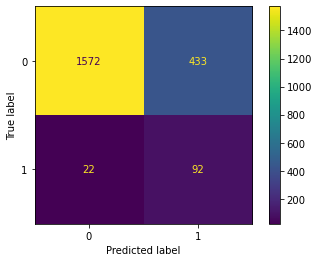

In [ ]:
plot_confusion_matrix(model_svc,X_test_sc,y_test)

In [ ]:
roc_auc_score(y_train,model_svc.predict(X_train_sc))

0.8075241738138794

In [ ]:
roc_auc_score(y_test,pred_svc)

0.7955287220545127

In [ ]:
score['SVC']={'train_acc':gs_smote_svc.score(X_train_sc,y_train),
              'val_acc':gs_smote_svc.best_score_,
              'test_acc':gs_smote_svc.score(X_test_sc,y_test),
              'train_auc':roc_auc_score(y_train,model_svc.predict(X_train_sc)),
              'test_auc':roc_auc_score(y_test,pred_svc),
              'train_recall':recall_score(y_train,model_svc.predict(X_train_sc)),
              'test_recall':recall_score(y_test,pred_svc)
}

### Pipeline: XGBoost with SMOTE

In [ ]:
pp_smote_xgb=Pipeline([
    ('sampling',SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, random_state=42))
])

In [ ]:
pp_smote_xgb_params={
    'sampling__k_neighbors': [5],
    'xgb__lambda': [0.2],
    'xgb__alpha': [0.1],
    'xgb__colsample_bytree': [0.9],
    'xgb__subsample': [0.8],
    'xgb__gamma': [0.4],
    'xgb__gpu_hist': ['gpu_hist'],
    'xgb__learning_rate': [0.1],
    'xgb__max_depth': [5],
    'xgb__min_child_weight': [2],
    'xgb__n_estimators': [100],
    'xgb__n_jobs': [-1],
    'xgb__verbosity': [2]
}

In [ ]:
gs_smote_xgb=GridSearchCV(pp_smote_xgb,pp_smote_xgb_params,cv=5,scoring='roc_auc',verbose=2)

In [ ]:
gs_smote_xgb.fit(X_train_sc,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:52:14] WARNING: ../src/learner.cc:541: 
Parameters: { gpu_hist } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:52:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[17:52:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:52:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 2 pruned nodes, max_depth=5
[17:52:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 4 pruned nodes, max_depth=5
[17:52:14] INFO: ../sr

[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 2 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 2 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 4 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 4 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[17:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 4 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[17:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 2 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 2 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 2 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[17:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 6 pruned no

[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 6 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 2 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 2 pruned nodes, max_depth=5
[17:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 2 pruned no

[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[17:52:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 2 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 2 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 2 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 2 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 4 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[17:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 2 pruned no

[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:52:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 2 pruned nodes, max_depth=5
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[17:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4

[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[17:52:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 2 pruned nodes, max_depth=5
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 2 pruned nodes, max_depth=5
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 6 pruned nodes, max_depth=5
[17:52:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 2 pruned no

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                          

In [ ]:
gs_smote_xgb.score(X_train_sc,y_train)

0.9140375638982399

In [ ]:
gs_smote_xgb.score(X_test_sc,y_test)

0.8594150588441178

In [ ]:
gs_smote_xgb.best_estimator_

Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.4,
                               gpu_hist='gpu_hist', gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', lambda=0.2,
                               learning_rate=0.1, max_delta_step=0, max_depth=5,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0.100000001, reg_lambda=0.200000003,
                               scale_pos_weight=1, subsample=0.8,
                               tree_method='exact', use_label_encoder=False,

In [ ]:
gs_smote_xgb.best_params_

{'sampling__k_neighbors': 5,
 'xgb__alpha': 0.1,
 'xgb__colsample_bytree': 0.9,
 'xgb__gamma': 0.4,
 'xgb__gpu_hist': 'gpu_hist',
 'xgb__lambda': 0.2,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__min_child_weight': 2,
 'xgb__n_estimators': 100,
 'xgb__n_jobs': -1,
 'xgb__subsample': 0.8,
 'xgb__verbosity': 2}

In [ ]:
model_xgb=gs_smote_xgb.best_estimator_

In [ ]:
pred_xgb=model_xgb.predict(X_test_sc)

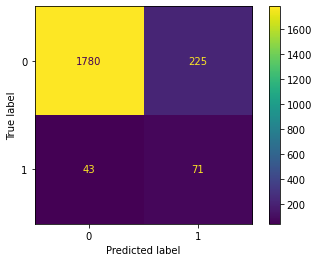

In [ ]:
plot_confusion_matrix(model_xgb,X_test_sc,y_test)

In [ ]:
roc_auc_score(y_train,model_xgb.predict(X_train_sc))

0.7972573030542668

In [ ]:
roc_auc_score(y_test,pred_xgb)

0.7552937830861443

In [ ]:
score['XGB']={'train_acc':gs_smote_xgb.score(X_train_sc,y_train),
              'val_acc':gs_smote_xgb.best_score_,
              'test_acc':gs_smote_xgb.score(X_test_sc,y_test),
              'train_auc':roc_auc_score(y_train,model_xgb.predict(X_train_sc)),
              'test_auc':roc_auc_score(y_test,pred_xgb),
              'train_recall':recall_score(y_train,model_xgb.predict(X_train_sc)),
              'test_recall':recall_score(y_test,pred_xgb)
}

In [ ]:
pd.DataFrame(score)

,LR,KNN,RF,ET,SVC,XGB
train_acc,0.815385,0.975321,0.901253,0.909615,0.877769,0.914038
val_acc,0.786691,0.742261,0.823720,0.820316,0.821797,0.822325
test_acc,0.825485,0.775244,0.854261,0.848064,0.854596,0.859415
train_auc,0.746293,0.916562,0.500000,0.508746,0.807524,0.797257
test_auc,0.756978,0.697616,0.504386,0.508772,0.795529,0.755294
train_recall,0.801749,0.959184,0.000000,0.017493,0.836735,0.696793
test_recall,0.798246,0.543860,0.008772,0.017544,0.807018,0.622807


### Model Selection & Evaluation of Results 

The metrics used for comparison are: Accuracy, AUC and Recall. 

**Accuracy**
<br>The results of the hyperparameter tuning above show that all models had relatively high training and cross-validated scores, indicating that some of the models may have overfit on the training data. However, after comparison with the test accuracy, we note that all models except KNN have test accuracies close to the training accuracies, which suggests that the models generalise well to new data. 

**AUC-ROC** 
<br> Due to the imbalanced classes in our dataset, the AUC-ROC curve allows us to assess how well our model performs at distinguishing between the positive and negative classes. We observe that the tree-based models (RF and ET) have the lowest scores of about 0.5, meaning that both models have no class separation capacity whatsoever.

The disparity between KNN's training and test AUC shows significantly higher degree of overfitting compared to the remaining 3 models. Of the 3, SVC has the highest score and also generalises well to new data. 


**Recall** 
<br> The final metric we use is recall (i.e sensitivity / true positivity rate). Given the severe imbalanced of WNV-positive (i.e WNV=1) classes, recall is an important metric for us to determine how well the model classifies whether the WNV is present in a given location, i.e we want to ensure that pesticides are sprayed in locations which have the WNV. From our results, SVC and LR have the best recall scores while the tree models are the worst-performing. 

Overall, SVC has the best performance in terms of the 3 metrics we're using. 

## Retrain On Full Dataset

In [ ]:
test=pd.read_csv('../datasets/test_weather.csv',index_col='id',parse_dates=['date'])

In [ ]:
test_08=test[test['date'].dt.year==2008][X_train_sc.columns]
test_10=test[test['date'].dt.year==2010][X_train_sc.columns]
test_12=test[test['date'].dt.year==2012][X_train_sc.columns]
test_14=test[test['date'].dt.year==2014][X_train_sc.columns]

In [ ]:
train_07=df_train[df_train['date'].dt.year==2007][X_train_sc.columns]
train_09=df_train[df_train['date'].dt.year<=2009][X_train_sc.columns]
train_11=df_train[df_train['date'].dt.year<=2011][X_train_sc.columns]
train_13=df_train[df_train['date'].dt.year<=2013][X_train_sc.columns]

In [ ]:
y_07=df_train[df_train['date'].dt.year==2007]['wnv']
y_09=df_train[df_train['date'].dt.year<=2009]['wnv']
y_11=df_train[df_train['date'].dt.year<=2011]['wnv']
y_13=df_train[df_train['date'].dt.year<=2013]['wnv']

In [ ]:
ss1=StandardScaler()
train_07_sc=ss1.fit_transform(train_07)
test_08_sc=ss1.transform(test_08)

In [ ]:
ss2=StandardScaler()
train_09_sc=ss2.fit_transform(train_09)
test_10_sc=ss1.transform(test_10)

In [ ]:
ss3=StandardScaler()
train_11_sc=ss3.fit_transform(train_11)
test_12_sc=ss1.transform(test_12)

In [ ]:
ss4=StandardScaler()
train_13_sc=ss3.fit_transform(train_13)
test_14_sc=ss1.transform(test_14)

In [ ]:
model_svc.fit(train_07_sc,y_07)

Pipeline(steps=[('sampling', SMOTE()),
                ('svc', SVC(C=0.2, kernel='poly', probability=True))])

In [ ]:
pred08=pd.DataFrame(model_svc.predict_proba(test_08_sc)[:,1],index=test_08.index,columns=['WnvPresent'])

In [ ]:
model_svc.fit(train_09_sc,y_09)

Pipeline(steps=[('sampling', SMOTE()),
                ('svc', SVC(C=0.2, kernel='poly', probability=True))])

In [ ]:
pred10=pd.DataFrame(model_svc.predict_proba(test_10_sc)[:,1],index=test_10.index,columns=['WnvPresent'])

In [ ]:
model_svc.fit(train_11_sc,y_11)

Pipeline(steps=[('sampling', SMOTE()),
                ('svc', SVC(C=0.2, kernel='poly', probability=True))])

In [ ]:
pred12=pd.DataFrame(model_svc.predict_proba(test_12_sc)[:,1],index=test_12.index,columns=['WnvPresent'])

In [ ]:
model_svc.fit(train_13_sc,y_13)

Pipeline(steps=[('sampling', SMOTE()),
                ('svc', SVC(C=0.2, kernel='poly', probability=True))])

In [ ]:
pred14=pd.DataFrame(model_svc.predict_proba(test_14_sc)[:,1],index=test_14.index,columns=['WnvPresent'])

In [ ]:
kaggle=pd.concat([pred08,pred10,pred12,pred14],axis=0)

In [ ]:
kaggle.to_csv('../datasets/kaggle.csv')

## Cost-Benefit Analysis 

As part of our cost-benefit analysis, we studied research papers which highlighted that an estimated \$778 million was incurred in both short-term and long-term, direct and indirect medical costs associated with the WNV disease, over a 15-year period from 1999 to 2014 across the US. 

<a href="https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article">Louisiana state data</a> showed that total epidemic costs were around \\$20 million for 329 cases, which averages to about \\$61,000 per infected case. We also explored a 2005 California economic cost analysis of the virus where the total economic impact was \\$2.98 million for 163 cases. This averaged the economic impact to around \\$18,282 per case, whereas vector control cost was \\$701,790. Their analysis also revealed that only <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/">15 cases</a> of WNV would need to be prevented to justify the cost of the pesticide spraying. 

However, their analysis is not backed up by our EDA process. Spatial data showing the spray locations did not show any noticeable reductions in the WNV-positive mosquito hot spot, thus we would recommend alternative measures to use in conjunction with the spraying. 

To increase the cost-effectiveness of pesticide spraying, we advise against spraying when average wind speeds are high (i.e below 10 mph) to reduce the occurrence of <a href="https://crops.extension.iastate.edu/cropnews/2017/01/wind-speed-and-herbicide-application#:~:text=specify%2010%20MPH%20as%20the,spray%20pressure%2C%20etc.).">spray drift</a>. Also, more mosquitoes tend to be caught in traps when wind speeds are lower. Spraying should be avoided above 86°F as the higher temperatures would cause pesticide droplets to <a href="https://grdc.com.au/__data/assets/pdf_file/0024/248181/GRDC-Weather-Essentials-for-Pesticide-Application-2017.pdf">evaporate faster</a> than in cooler air. Results from the EDA showed that the virus is only prevalent during the months of July to September, and thus any efforts to reduce the mosquito population should be focused on this time period. 

We recommend that The Department of Public Health consider cost-friendly measures such as eliminating mosquito breeding grounds by covering up areas where water tends to collect and remain stagnant, e.g still ponds, flower pots, rainwater barrels, etc. preventing excessive breeding after periods of heavy rainfall. This is backed up by our EDA which shows an increase in WNV counts after a spike in the precipitation total. In addition, mosquito bites can also be reduced by using mosquito repellent, and wearing long pants and long-sleeves. 

Overall, our findings show that the benefits of increasing pesticide spraying may not outweigh the costs incurred. Therefore, we propose a combination of proactive (eg. spraying of pesticides)and reactive (eg. cover up mosquito breeding grounds) measures to combat the spread of the WNV in a more cost-efficient manner. 

## Conclusion  

Our best performing model is SVM with a test accuracy score of 85.5%. Although accuracy provides an overview of the model's performance, we need to consider the other metrics to gain more meaningful insights to guide the decisions of the Chicago Department of Public Health. 

Other key metrics include the AUC, which shows that our model is 79.6% capable of distinguishing between WNV-positive and WNV-negative classes. We also note the recall rate which indicates that 80.7% of the actual WNV-positive cases were correctly classified. 

Based on these 3 metrics, we conclude that our model has performed relatively well in its classification of WNV-positive mosquitoes. This, in conjunction with the findings from the EDA and cost-benefit analysis, would help the Department of Public Health in making better decisions on when and where to spray pesticides to combat the spread of the WNV-virus. 
